#SPDX-FileCopyrightText: 2024 David Fernandes del Pozo <david.fernandesdelpozo@ugent.be>, <fernandesdelpozo.david@gmail.com>

#SPDX-License-Identifier: GPL-3.0

# BSM1 Model with Point Settler model

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from   scipy.integrate import ode, odeint, solve_ivp
from   tqdm.notebook import tqdm_notebook
from   tqdm import tqdm



# Prints current Python version
print("Current version of Python is ", sys.version)
print("Current version of Scipy is ", scipy.__version__)


# Change some matplotlib settings
plt.rcParams
matplotlib.rcdefaults()
plt.rcParams['mathtext.fontset'] = "cm"

Current version of Python is  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Current version of Scipy is  1.11.1


### Steady State BSM1 values for Influent feed

In [2]:
# Average feed load concentrations
df_SS_inlet = pd.DataFrame([[30,69.5,51.2,202.32,28.17,0,0,0,0,31.56,6.95,10.59,7,18446]])
df_SS_inlet.columns =      ['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND','SALK','Q']

In [3]:
# Average Feed load concentrations
SIf  = df_SS_inlet['SI'][0]        # [g COD/m³] 
SSf  = df_SS_inlet['SS'][0]        # [g COD/m³]  
XIf  = df_SS_inlet['XI'][0]        # [g COD/m³] 
XSf  = df_SS_inlet['XS'][0]        # [g COD/m³]
XBHf = df_SS_inlet['XBH'][0]       # [g COD/m³]
XBAf = df_SS_inlet['XBA'][0]       # [g COD/m³]
XPf  = df_SS_inlet['XP'][0]        # [g COD/m³]
SOf  = df_SS_inlet['SO'][0]        # [g COD/m³]
SNOf = df_SS_inlet['SNO'][0]       # [g NO/m³]
SNHf = df_SS_inlet['SNH'][0]       # [g NH/m³]
SNDf = df_SS_inlet['SND'][0]       # [g N/m³]
XNDf = df_SS_inlet['XND'][0]       # [g N/m³]

### Define the ASM + BSM1 model constants and parameters

In [4]:
# Stoichiometry 
YA  = 0.24;     # Autotrophic yield                                         [g COD formed/(g N oxidized)]
YH  = 0.67;     # Heterotrophic yield                                       [g COD formed/(g COD oxidized)]
fP  = 0.08;     # Fraction of biomass yielding particulate products         [-]
iXB = 0.08;     # Mass of nitrogen per mass of COD in biomass               [g N/(g COD) in biomass] 
iXP = 0.06;     # Mass of nitrogen per mass of COD in products from biomass [g N/(g COD) in particulate products]

# Kinetics parameters
µH    = 4.0;    # Max. specific growth rate for heterotrophic biomass                          [1/d]
KS    = 10;     # Half-saturation coefficient for heterotrophic biomass                        [g/m³]
KOH   = 0.2;    # Oxygen half-saturation coefficient for heterotrophic biomass                 [g/m³]
KNO   = 0.5;    # Nitrate half-saturation coefficient for denitrifying heterotrophic biomass   [g/m³]
bH    = 0.3;    # Decay coefficient for heterotrophic biomass                                  [1/d]
etag  = 0.8;    # Correction factor for muH under anoxic conditions                            [-]
etah  = 0.8;    # Correction factor for hydrolysis under anoxic conditions                     [-]
kh    = 3.0;    # Maximum specific hydrolysis rate                                             [1/d]
KX    = 0.1;    # Half-saturation coefficient for hydrolysis of slowly biodegradable substrate [-]
µA    = 0.5;    # Maximum specific growth rate for autotrophic biomass                         [1/d]
KNH   = 1;      # Ammonia half-saturation coefficient for autotrophic biomass                  [g/m³]
KOA   = 0.4;    # Oxygen half-saturation coefficient for autotrophic biomass                   [g/m³]
bA    = 0.05;   # Decay coefficient for autotrophic biomass                                    [1/day]
ka    = 0.05;   # Ammonification rate                                                          [m³/g/day]
kLa   = 240;    # Oxygen mass transfer coefficient                                             [1/d] 
## Close loop value = 3.5 [1/h]
kLa_5 = 84;     # Oxygen mass transfer coefficient of 5th tank                                 [1/day]
SOsat = 8;      # Oxygen saturation concentration                                              [g/m³]

### Flow Rates

In [5]:
# Definition of flow rates
Qf = df_SS_inlet['Q'][0]    # [m³/d]           
# Wastage flow rate (to control solids accumulation and purge inerts) 
Qw =  385                   # [m³/d]          
# Flow rate of internal recirculation (assumed to be based on the feed flow rate at that instant)
Qa = 3*Qf                   # [m³/d]
# Inflow to settler
Qo = 2*Qf                   # [m³/d]
# Underflow from settler
Qs = Qf+Qw                  # [m³/d]
# Overflow from settler
Qe = Qf-Qw                  # [m³/d]     
# Recirculated flow rate from settler 
Qr = Qf                     # [m³/d]          
# Recirculation flow rate from settler and for denitrification
Qra = Qa + Qr               # [m³/d]
# Inlet flow rate of aerated tanks 
Qi = Qf + Qra               # [m³/d]  
# Flow rates between tanks
Q1 = Q2 = Q3 = Q4 = Qi      # [m³/d]
# Particulate components are splitted according to the non-settleable fraction (point fractionation model)
# We estimated based on the SS values of the first and last layer of the BSM1 Tacáks settler model
fns = 12.5 / (12.5 + 6394)  # [-]

# Definition of volumes    
V1,V2,V3,V4,V5 = 1000,1000,1333,1333,1333 # [m³/d]

### Activated Sludge Model No.1 (ASM1)

In [6]:
#•Define ASM Process rates
def process_rates(SS, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND):
    '''Process rates'''

    rho = np.zeros(8)
    # Aerobic growth of heterotrophs
    rho[0] = µH*(SS/(KS+SS))*(SO/(KOH+SO))*XBH
    # Anoxic growth of heterotrophs
    rho[1] = µH*(SS/(KS+SS))*(KOH/(KOH+SO))*(SNO/(KNO+SNO))*etag*XBH
    # Aerobic growth of autotrophs
    rho[2] = µA*(SNH/(KNH+SNH))*(SO/(KOA+SO))*XBA
    # Decay of heterotrophs
    rho[3] = bH*XBH
    # Decay of autotrophs
    rho[4] = bA*XBA
    # Ammonification of soluble organic nitrogen
    rho[5] = ka*SND*XBH
    # Hydrolysis of entrapped organics
    rho[6] = kh*((XS/XBH)/(KX+(XS/XBH)))*(((SO/(KOH+SO))) \
             + etah*(KOH/(KOH+SO))*(SNO/(KNO+SNO)))*XBH
    # Hydrolysis of entrapped organic nitrogen
    rho[7] = rho[6]*(XND/XS)
    return rho

#•Define ASM Conversion rates 
def conversion_rates(rho):
    '''conversion rates'''

    r = np.zeros(12)
    # Soluble inert organic matter SI
    r[0] = 0
    # Readily biodegradable substrate SS
    r[1]  = (-1/YH)*(rho[0] + rho[1]) + rho[6] 
    # Particulate inert organic matter XI
    r[2] = 0
    # Slowly biodegradable substrate XS
    r[3]  = (1-fP)*(rho[3] + rho[4]) - rho[6] 
    # Active heterotrophic biomass XBH
    r[4] =  rho[0] + rho[1] - rho[3] 
    # Active autotrophic biomass XBA
    r[5] = rho[2] - rho[4] 
    # Particulate products arising from biomass decay XP
    r[6]  = fP*(rho[3] + rho[4]) 
    # Oxygen SO   
    r[7]  = (-(1-YH)/YH)*rho[0] + (-(4.57-YA)/YA)*rho[2] 
    # Nitrate and nitrite nitrogen SNO
    r[8] = (-(1-YH)/(2.86*YH))*rho[1] + (1/YA)*rho[2] 
    # NH4+/NH3 nitrogen SNH
    r[9] = -iXB*(rho[0] + rho[1]) - (iXB+1/YA)*rho[2] + rho[5] 
    # Soluble biodegradable organic nitrogen SND
    r[10] = -rho[5] + rho[7] 
    # Particulate biodegradable organic nitrogen XND
    r[11] = (iXB - fP*iXP)*(rho[3] + rho[4]) - rho[7] 

    return r


### Benchmark Simulation Model No.1 (BSM1)

In [7]:
def derivatives_reactor(V, Q, Cin, C, aeration=False, kla_DO=False):  
    
    SI, SS, XI, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND = C[:]
    SIin, SSin, XIin, XSin, XBHin, XBAin, XPin, SOin, SNOin, SNHin, SNDin, XNDin = Cin[:]

    # Define Process rates
    rho = process_rates(SS, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND)
    # Define conversion rates
    r = conversion_rates(rho)
     
    '''Mass Balances Tank '''
    dCdt = np.zeros(12)
    # Soluble inert organic matter SI
    dCdt[0]  = r[0] + Q/V*(SIin - SI)
    # Readily biodegradable substrate SS
    dCdt[1]  = r[1] + Q/V*(SSin - SS)
    # Particulate inert organic matter XI
    dCdt[2]  = r[2] + Q/V*(XIin - XI)
    # Slowly biodegradable substrate XS
    dCdt[3]  = r[3] + Q/V*(XSin - XS)
    # Active heterotrophic biomass XBH
    dCdt[4]  = r[4] + Q/V*(XBHin - XBH) 
    # Active autotrophic biomass XBA
    dCdt[5]  = r[5] + Q/V*(XBAin - XBA) 
    # Particulate products arising from biomass decay XP
    dCdt[6]  = r[6] + Q/V*(XPin - XP)
    # Oxygen SO
    if aeration:
        if (kla_DO == False):
            dCdt[7]  = r[7] + Q/V*(SOin - SO) + kLa*(SOsat - SO)
        else:
            dCdt[7]  = r[7] + Q/V*(SOin - SO) + kLa_5*(SOsat - SO)    
    else:
            dCdt[7]  = r[7] + Q/V*(SOin - SO)
    # Nitrate and nitrite nitrogen SNO
    dCdt[8]  = r[8] + Q/V*(SNOin - SNO) 
    # NH4+/NH3 nitrogen SNH
    dCdt[9]  = r[9] + Q/V*(SNHin - SNH) 
    # Soluble biodegradable organic nitrogen SND
    dCdt[10] = r[10] + Q/V*(SNDin - SND) 
    # Particulate biodegradable organic nitrogen XND
    dCdt[11] = r[11] + Q/V*(XNDin - XND) 
    
    return dCdt

### Function used for ```ode``` and ```solve_ivp```

In [8]:
#-------------------------------------------------------------------------------------------------------------------------------
def ODE(t, C):
    '''Function to build a system of ODEs for 5 tanks with point settler model'''
    # Initial conditions (concentrations)
    # Tank 1
    SI1,SS1,XI1,XS1,XBH1,XBA1,XP1,SO1,SNO1,SNH1,SND1,XND1 = C[0:12]
    # Tank 2
    SI2,SS2,XI2,XS2,XBH2,XBA2,XP2,SO2,SNO2,SNH2,SND2,XND2 = C[12:24]  
    # Tank 3
    SI3,SS3,XI3,XS3,XBH3,XBA3,XP3,SO3,SNO3,SNH3,SND3,XND3 = C[24:36]  
    # Tank 4
    SI4,SS4,XI4,XS4,XBH4,XBA4,XP4,SO4,SNO4,SNH4,SND4,XND4 = C[36:48]  
    # Tank 5
    SI5,SS5,XI5,XS5,XBH5,XBA5,XP5,SO5,SNO5,SNH5,SND5,XND5 = C[48:60]
  
    # Definition of inlet values 
    # Recalculation of inlet values for soluble and particulate matter.
    SIi  = 1/Qi*(Qf*SIf  + Qra*SI5)
    SSi  = 1/Qi*(Qf*SSf  + Qra*SS5)
    XIi  = 1/Qi*(Qf*XIf  + Qa *XI5 +Qr/Qs*(Qo*XI5-Qe*fns*XI5))
    XSi  = 1/Qi*(Qf*XSf  + Qa *XS5 +Qr/Qs*(Qo*XS5-Qe*fns*XS5))
    XBHi = 1/Qi*(Qf*XBHf + Qa *XBH5+Qr/Qs*(Qo*XBH5-Qe*fns*XBH5))
    XBAi = 1/Qi*(Qf*XBAf + Qa *XBA5+Qr/Qs*(Qo*XBA5-Qe*fns*XBA5))
    XPi  = 1/Qi*(Qf*XPf  + Qa *XP5 +Qr/Qs*(Qo*XP5-Qe*fns*XP5))
    SOi  = 1/Qi*(Qf*SOf  + Qra*SO5)
    SNOi = 1/Qi*(Qf*SNOf + Qra*SNO5)
    SNHi = 1/Qi*(Qf*SNHf + Qra*SNH5)
    SNDi = 1/Qi*(Qf*SNDf + Qra*SND5)
    XNDi = 1/Qi*(Qf*XNDf + Qa *XND5+Qr/Qs *(Qo*XND5-Qe*fns*XND5))

    dCdt = np.zeros(60)

    # Definition of mass balances    
    # Anoxic tanks 
    '''Mass Balances Tank 1'''
    dCdt[0:12] = \
        derivatives_reactor(V1,Qi, \
                [SIi, SSi, XIi, XSi, XBHi, XBAi, XPi, SOi, SNOi, SNHi, SNDi, XNDi], \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1],  aeration=False)

    '''Mass Balances Tank 2'''
    dCdt[12:24] = \
        derivatives_reactor(V2,Q1, \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1], \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2],  aeration=False) 

    # Aerated tanks
    '''Mass Balances Tank 3'''
    dCdt[24:36] = \
        derivatives_reactor(V3,Q2, \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2], \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], aeration=True,kla_DO=False)                                                                              

    '''Mass Balances Tank 4'''
    dCdt[36:48] = \
        derivatives_reactor(V4,Q3, \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], aeration=True,kla_DO=False)
    
    # Aerated tank (optionally change kla_5 if run in open-loop)
    '''Mass Balances Tank 5'''
    dCdt[48:60] = \
        derivatives_reactor(V5,Q4, \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], \
                [SI5, SS5, XI5, XS5, XBH5, XBA5, XP5, SO5, SNO5, SNH5, SND5, XND5], aeration=True,kla_DO=True) 
                                                                                    
    return dCdt
    
#------------------------------------------------------------------------------------------------------------------------------


### Function used for ```odeint```

In [9]:
#-------------------------------------------------------------------------------------------------------------------------------
def ODEint(C,t):
    '''Function to build a system of ODEs for 5 tanks with point settler model'''
    # Initial conditions (concentrations)
    # Tank 1
    SI1,SS1,XI1,XS1,XBH1,XBA1,XP1,SO1,SNO1,SNH1,SND1,XND1 = C[0:12]
    # Tank 2
    SI2,SS2,XI2,XS2,XBH2,XBA2,XP2,SO2,SNO2,SNH2,SND2,XND2 = C[12:24]  
    # Tank 3
    SI3,SS3,XI3,XS3,XBH3,XBA3,XP3,SO3,SNO3,SNH3,SND3,XND3 = C[24:36]  
    # Tank 4
    SI4,SS4,XI4,XS4,XBH4,XBA4,XP4,SO4,SNO4,SNH4,SND4,XND4 = C[36:48]  
    # Tank 5
    SI5,SS5,XI5,XS5,XBH5,XBA5,XP5,SO5,SNO5,SNH5,SND5,XND5 = C[48:60]
  
    # Definition of inlet values 
    # Recalculation of inlet values for soluble and particulate matter.
    SIi  = 1/Qi*(Qf*SIf  + Qra*SI5)
    SSi  = 1/Qi*(Qf*SSf  + Qra*SS5)
    XIi  = 1/Qi*(Qf*XIf  + Qa *XI5 +Qr/Qs*(Qo*XI5-Qe*fns*XI5))
    XSi  = 1/Qi*(Qf*XSf  + Qa *XS5 +Qr/Qs*(Qo*XS5-Qe*fns*XS5))
    XBHi = 1/Qi*(Qf*XBHf + Qa *XBH5+Qr/Qs*(Qo*XBH5-Qe*fns*XBH5))
    XBAi = 1/Qi*(Qf*XBAf + Qa *XBA5+Qr/Qs*(Qo*XBA5-Qe*fns*XBA5))
    XPi  = 1/Qi*(Qf*XPf  + Qa *XP5 +Qr/Qs*(Qo*XP5-Qe*fns*XP5))
    SOi  = 1/Qi*(Qf*SOf  + Qra*SO5)
    SNOi = 1/Qi*(Qf*SNOf + Qra*SNO5)
    SNHi = 1/Qi*(Qf*SNHf + Qra*SNH5)
    SNDi = 1/Qi*(Qf*SNDf + Qra*SND5)
    XNDi = 1/Qi*(Qf*XNDf + Qa *XND5+Qr/Qs *(Qo*XND5-Qe*fns*XND5))

    dCdt = np.zeros(60)

    # Definition of mass balances    
    # Anoxic tanks 
    '''Mass Balances Tank 1'''
    dCdt[0:12] = \
        derivatives_reactor(V1,Qi, \
                [SIi, SSi, XIi, XSi, XBHi, XBAi, XPi, SOi, SNOi, SNHi, SNDi, XNDi], \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1],  aeration=False)

    '''Mass Balances Tank 2'''
    dCdt[12:24] = \
        derivatives_reactor(V2,Q1, \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1], \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2],  aeration=False) 

    # Aerated tanks
    '''Mass Balances Tank 3'''
    dCdt[24:36] = \
        derivatives_reactor(V3,Q2, \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2], \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], aeration=True,kla_DO=False)                                                                              

    '''Mass Balances Tank 4'''
    dCdt[36:48] = \
        derivatives_reactor(V4,Q3, \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], aeration=True,kla_DO=False)
    
    # Aerated tank (optionally change kla_5 if run in open-loop)
    '''Mass Balances Tank 5'''
    dCdt[48:60] = \
        derivatives_reactor(V5,Q4, \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], \
                [SI5, SS5, XI5, XS5, XBH5, XBA5, XP5, SO5, SNO5, SNH5, SND5, XND5], aeration=True,kla_DO=True) 
                                                                                    
    return dCdt
    
#------------------------------------------------------------------------------------------------------------------------------

### Initialisation

In [10]:
# Initialisation based on influent values (but providing some XBA and SNO to start growth)
C0 = np.array([SIf, SSf, XIf, XSf, XBHf, 50, XPf, 0, 2, SNHf, SNDf, XNDf,   #Tank1
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 0, 2, SNHf, SNDf, XNDf,   #Tank2
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 8, 2, SNHf, SNDf, XNDf,   #Tank3
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 8, 2, SNHf, SNDf, XNDf,   #Tank4
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 2, 2, SNHf, SNDf, XNDf])  #Tank5

### Time Information

Time settings for plotting different solvers over 50 days

In [11]:
# Set time information
dt     = 0.05     # [d]
tStart = 0        # [d]
tEnd   = 50       # [d]
t_plot = np.linspace(tStart, tEnd, int((tEnd-tStart)/dt))

## Using solver from `scipy.integrate.ode`

In [12]:
# Set up the ODE integrator
r = ode(ODE) #ode(function, y, args)
r.set_integrator("vode", method="adams", with_jacobian=False, nsteps = 10000)
#r.set_integrator("lsoda")
r.set_initial_value(C0, tStart)

# Define dataframes for storage of 5-tank and settler data

# Tanks
system_data_ode = pd.DataFrame(columns=["time", 
                                   "SI1", "SS1", "XI1", "XS1", "XBH1", "XBA1", 
                                   "XP1", "SO1", "SNO1", "SNH1", "SND1", "XND1",
                                   "SI2", "SS2", "XI2", "XS2", "XBH2", "XBA2", 
                                   "XP2", "SO2", "SNO2", "SNH2", "SND2", "XND2",
                                   "SI3", "SS3", "XI3", "XS3", "XBH3", "XBA3", 
                                   "XP3", "SO3", "SNO3", "SNH3", "SND3", "XND3",
                                   "SI4", "SS4", "XI4", "XS4", "XBH4", "XBA4", 
                                   "XP4", "SO4", "SNO4", "SNH4", "SND4", "XND4",
                                   "SI5", "SS5", "XI5", "XS5", "XBH5", "XBA5", 
                                   "XP5", "SO5", "SNO5", "SNH5", "SND5", "XND5",],
                        dtype='float')

# Store initial values for the 5 tank biological reactor
system_data_ode.loc[0] = [tStart] + [C0[j] for j in range(len(C0))]

# Solve ODE
# Initiliaze counter
i = 1
# installation of progress bar
with tqdm_notebook(total=int((tEnd - tStart) / dt), desc="Simulation Progress") as pbar:
# Iterate until both conditions are satisfied
    while r.successful() and r.t < tEnd:
        # Perform integration step
        r.integrate(r.t+dt)
        # Store results
        system_data_ode.loc[i] = [r.t] + [r.y[j] for j in range(len(r.y))]
        # Update counter
        i += 1
        # Update progress bar
        pbar.update(1)

Simulation Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
system_data_ode

,time,SI1,SS1,XI1,XS1,XBH1,XBA1,XP1,SO1,SNO1,...,XI5,XS5,XBH5,XBA5,XP5,SO5,SNO5,SNH5,SND5,XND5
0,0.00,30.0,69.500000,51.200000,202.320000,28.170000,50.000000,0.000000,0.000000,2.000000,...,51.200000,202.320000,28.170000,50.000000,0.000000,2.000000,2.000000,31.560000,6.950000,10.590000
1,0.05,30.0,66.623061,62.972662,244.932552,39.434098,50.256239,0.048632,0.389781,4.500440,...,54.626842,211.978438,34.812909,50.682033,0.048173,4.008767,5.665230,27.695714,6.647794,11.111661
2,0.10,30.0,63.404987,70.447674,269.442322,49.637996,50.641459,0.108497,0.339927,6.545075,...,62.359258,237.432732,45.244177,51.068141,0.108619,3.872096,8.159503,24.779053,6.314033,12.463802
3,0.15,30.0,59.788766,77.847435,292.327108,61.323625,51.024127,0.181067,0.293372,8.197727,...,69.805996,260.436559,57.032483,51.461009,0.181700,3.723139,10.208080,22.312578,5.977303,13.691260
4,0.20,30.0,55.774947,85.209174,313.583774,74.646771,51.394172,0.268191,0.250879,9.486985,...,77.220444,281.815203,70.481486,51.841579,0.269447,3.561766,11.827070,20.250463,5.640512,14.837629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,49.85,30.0,2.755962,1195.752331,82.787939,2610.611577,154.354632,477.150879,0.004210,5.386269,...,1195.740912,49.941473,2617.815277,155.763008,480.577003,0.489783,10.468067,1.499496,0.682685,3.580636
998,49.90,30.0,2.755960,1195.762783,82.787910,2610.612120,154.355946,477.160632,0.004210,5.386318,...,1195.751439,49.941451,2617.815818,155.764332,480.586826,0.489788,10.468129,1.499431,0.682685,3.580635
999,49.95,30.0,2.755957,1195.773166,82.787881,2610.612658,154.357251,477.170322,0.004210,5.386367,...,1195.761897,49.941428,2617.816353,155.765646,480.596586,0.489793,10.468190,1.499367,0.682685,3.580633
1000,50.00,30.0,2.755955,1195.783481,82.787852,2610.613191,154.358546,477.179949,0.004210,5.386416,...,1195.772286,49.941406,2617.816885,155.766951,480.606282,0.489798,10.468251,1.499303,0.682685,3.580632


In [14]:
# Steady state results
Rows = ['SI', 'SS', 'XI', 'XS', 'XBH', 'XBA', 'XP', 'SO', 'SNO', 'SNH', 'SND', 'XND']
Columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
Steady_State_ode = pd.DataFrame(index = Rows, columns = Columns)
for r in Rows:
    tank = 1
    for c in Columns:
        Steady_State_ode.loc[r, c] = f'{system_data_ode[r + str(tank)].iloc[-1]:.2f}' #eerst loc dan iloc!!!
        tank += 1

Steady_State_ode

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,30.00,30.00,30.00,30.00,30.00
SS,2.76,1.44,1.14,0.99,0.88
XI,1195.79,1195.79,1195.79,1195.79,1195.78
XS,82.79,77.06,65.51,56.33,49.94
XBH,2610.61,2612.13,2615.78,2617.75,2617.82
XBA,154.36,154.28,154.92,155.51,155.77
XP,477.19,477.87,478.79,479.70,480.62
SO,0.00,0.00,1.64,2.37,0.49
SNO,5.39,3.66,6.60,9.39,10.47
SNH,7.74,8.17,5.31,2.70,1.50


### Using solver from `scipy.integrate.odeint`

In [15]:
sol = odeint(ODEint, C0, t_plot)

system_data_odeint = pd.DataFrame(columns=["time", 
                                   "SI1", "SS1", "XI1", "XS1", "XBH1", "XBA1", 
                                   "XP1", "SO1", "SNO1", "SNH1", "SND1", "XND1",
                                   "SI2", "SS2", "XI2", "XS2", "XBH2", "XBA2", 
                                   "XP2", "SO2", "SNO2", "SNH2", "SND2", "XND2",
                                   "SI3", "SS3", "XI3", "XS3", "XBH3", "XBA3", 
                                   "XP3", "SO3", "SNO3", "SNH3", "SND3", "XND3",
                                   "SI4", "SS4", "XI4", "XS4", "XBH4", "XBA4", 
                                   "XP4", "SO4", "SNO4", "SNH4", "SND4", "XND4",
                                   "SI5", "SS5", "XI5", "XS5", "XBH5", "XBA5", 
                                   "XP5", "SO5", "SNO5", "SNH5", "SND5", "XND5",],
                        dtype='float')

system_data_odeint['time'] = t_plot

for col_index,col in enumerate(system_data_odeint.columns[1:]):
    system_data_odeint[col] = sol[:,col_index]

### Using solver from `scipy.integrate.solve_ivp`

In [16]:
# Set time information
dt     = 0.05     # [d]
tStart = 0        # [d]
tEnd   = 50      # [d]

In [17]:
# Solve_ivp without loop
sol = solve_ivp(ODE, (tStart, tEnd), C0, method="BDF")

system_data_ivp = pd.DataFrame(columns=["time", 
                                   "SI1", "SS1", "XI1", "XS1", "XBH1", "XBA1", 
                                   "XP1", "SO1", "SNO1", "SNH1", "SND1", "XND1",
                                   "SI2", "SS2", "XI2", "XS2", "XBH2", "XBA2", 
                                   "XP2", "SO2", "SNO2", "SNH2", "SND2", "XND2",
                                   "SI3", "SS3", "XI3", "XS3", "XBH3", "XBA3", 
                                   "XP3", "SO3", "SNO3", "SNH3", "SND3", "XND3",
                                   "SI4", "SS4", "XI4", "XS4", "XBH4", "XBA4", 
                                   "XP4", "SO4", "SNO4", "SNH4", "SND4", "XND4",
                                   "SI5", "SS5", "XI5", "XS5", "XBH5", "XBA5", 
                                   "XP5", "SO5", "SNO5", "SNH5", "SND5", "XND5",],
                        dtype='float')

system_data_ivp['time'] = sol.t

for col_index,col in enumerate(system_data_ivp.columns[1:]):
    system_data_ivp[col] = sol.y[col_index,:]

In [18]:
# Steady state results
Rows = ['SI', 'SS', 'XI', 'XS', 'XBH', 'XBA', 'XP', 'SO', 'SNO', 'SNH', 'SND', 'XND']
Columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
Steady_State_ivp = pd.DataFrame(index = Rows, columns = Columns)
i = 0
for c in Columns:
    for r in Rows:
        Steady_State_ivp.loc[r, c] = f'{sol.y[i, -1]:.2f}'
        i += 1

Steady_State_ivp

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,30.00,30.00,30.00,30.00,30.00
SS,2.76,1.44,1.14,0.99,0.88
XI,1195.69,1195.69,1195.68,1195.68,1195.68
XS,82.79,77.06,65.51,56.33,49.94
XBH,2610.61,2612.13,2615.78,2617.75,2617.81
XBA,154.34,154.26,154.90,155.49,155.75
XP,477.10,477.78,478.69,479.61,480.52
SO,0.00,0.00,1.64,2.37,0.49
SNO,5.39,3.66,6.60,9.39,10.47
SNH,7.74,8.17,5.31,2.70,1.50


### BSM1 SS values

In [19]:
# BSM1 outlet values
df_SS = pd.DataFrame([[30, 2.8082, 1149.1183, 82.1349, 2551.7631, 148.3886, 448.8459, 0.0042984, 5.3699, 7.9179, 1.2166, 5.2849],
                    [30, 1.4588, 1149.1182, 76.3862, 2553.3824, 148.3083, 449.5167, 0.000063132, 3.6619 , 8.3445, 0.88207 ,5.0291],
                    [30, 1.1495, 1149.1182, 64.8549, 2557.1288, 148.9404, 450.4123, 1.7184, 6.5408, 5.548, 0.82889, 4.3924],
                    [30, 0.99532, 1149.1182, 55.694, 2559.18, 149.5262, 451.3087, 2.4289, 9.299, 2.9674, 0.76679, 3.879],
                    [30, 0.88949, 1149.1182, 49.3056, 2559.341, 149.7963, 452.2051, 0.49094, 10.4152, 1.7334, 0.68828, 3.5272]])
df_SS.columns =['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND']
df_SS = df_SS.transpose()
df_SS.columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
df_SS

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,30.000000,30.000000,30.00000,30.00000,30.00000
SS,2.808200,1.458800,1.14950,0.99532,0.88949
XI,1149.118300,1149.118200,1149.11820,1149.11820,1149.11820
XS,82.134900,76.386200,64.85490,55.69400,49.30560
XBH,2551.763100,2553.382400,2557.12880,2559.18000,2559.34100
XBA,148.388600,148.308300,148.94040,149.52620,149.79630
XP,448.845900,449.516700,450.41230,451.30870,452.20510
SO,0.004298,0.000063,1.71840,2.42890,0.49094
SNO,5.369900,3.661900,6.54080,9.29900,10.41520
SNH,7.917900,8.344500,5.54800,2.96740,1.73340


### Error between simulated data (with ```solve_ivp```) and BSM1 SS values

In [20]:
Rows = ['SI', 'SS', 'XI', 'XS', 'XBH', 'XBA', 'XP', 'SO', 'SNO', 'SNH', 'SND', 'XND']
Columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
error = pd.DataFrame(index = Rows, columns = Columns)
for c in Columns:
    for r in Rows:
        error.loc[r, c] = f'{100*np.abs(float(Steady_State_ivp.loc[r, c]) - df_SS.loc[r, c])/df_SS.loc[r, c]:.2f}'

error

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,0.00,0.00,0.00,0.00,0.00
SS,1.72,1.29,0.83,0.53,1.07
XI,4.05,4.05,4.05,4.05,4.05
XS,0.80,0.88,1.01,1.14,1.29
XBH,2.31,2.30,2.29,2.29,2.28
XBA,4.01,4.01,4.00,3.99,3.97
XP,6.29,6.29,6.28,6.27,6.26
SO,100.00,100.00,4.56,2.42,0.19
SNO,0.37,0.05,0.91,0.98,0.53
SNH,2.25,2.09,4.29,9.01,13.46


# Plot Results over 50 days

In [21]:
# BSM1 outlet values
df_SS_outlet = pd.DataFrame([[30,0.889,1149.17,49.3,2559.34,149.80,452.20,0.491,10.41,1.73,0.688,3.53]])
df_SS_outlet.columns =['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND']

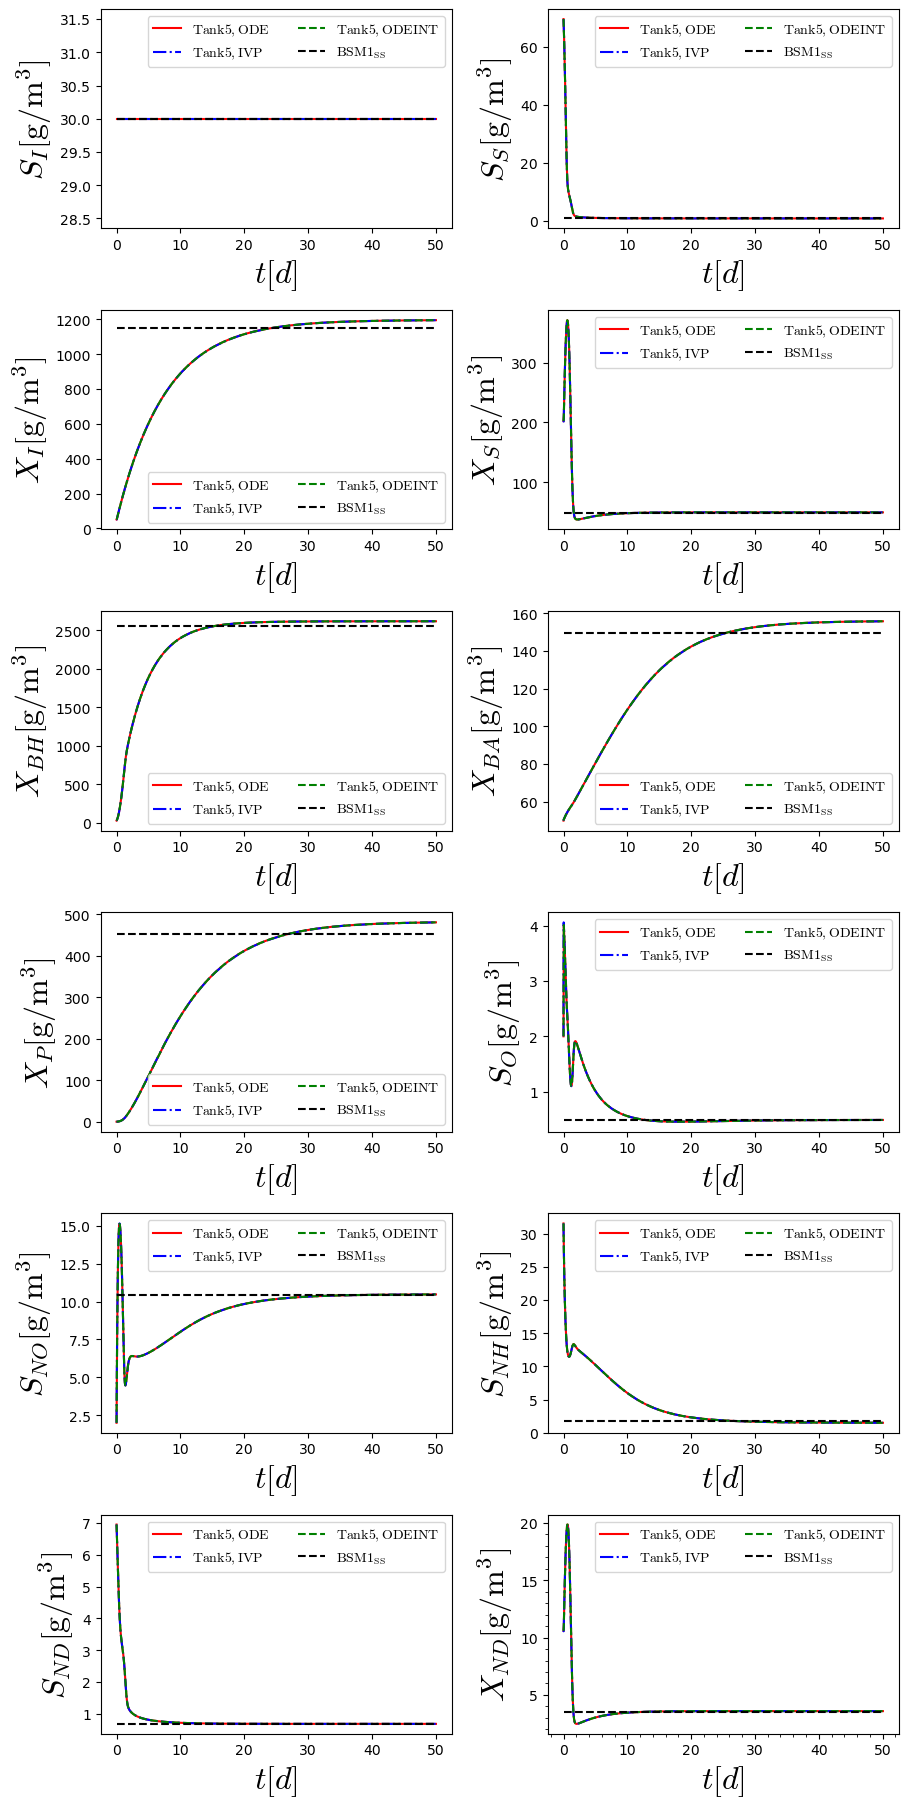

In [22]:
step = 5

fig, axs = plt.subplots(6, 2, figsize=(9, 18))
plt.minorticks_on()

# Plot the soluble inert organic matter (SI)
axs[0, 0].plot(system_data_ode["time"], system_data_ode["SI5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[0, 0].plot(system_data_ivp["time"], system_data_ivp["SI5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[0, 0].plot(system_data_odeint["time"], system_data_odeint["SI5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[0, 0].plot([0, tEnd], [df_SS_outlet["SI"], df_SS_outlet["SI"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[0, 0].legend(fontsize=10, ncol=2)
axs[0, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[0, 0].set_ylabel(r'$S_I \mathrm{[g/m^3]}$', fontsize=23)

# Plot the readily biodegradable substrate (SS)
axs[0, 1].plot(system_data_ode["time"], system_data_ode["SS5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[0, 1].plot(system_data_ivp["time"], system_data_ivp["SS5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[0, 1].plot(system_data_odeint["time"], system_data_odeint["SS5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[0, 1].plot([0, tEnd], [df_SS_outlet["SS"], df_SS_outlet["SS"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[0, 1].legend(fontsize=10, ncol=2)
axs[0, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[0, 1].set_ylabel(r'$S_S \mathrm{[g/m^3]}$', fontsize=23)

# Plot the particulate inert organic matter (XI)
axs[1, 0].plot(system_data_ode["time"], system_data_ode["XI5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[1, 0].plot(system_data_ivp["time"], system_data_ivp["XI5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[1, 0].plot(system_data_odeint["time"], system_data_odeint["XI5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[1, 0].plot([0, tEnd], [df_SS_outlet["XI"], df_SS_outlet["XI"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[1, 0].legend(fontsize=10, ncol=2)
axs[1, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[1, 0].set_ylabel(r'$X_I \mathrm{[g/m^3]}$', fontsize=23)

# Plot the slowly biodegradable substrate (XS)
axs[1, 1].plot(system_data_ode["time"], system_data_ode["XS5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[1, 1].plot(system_data_ivp["time"], system_data_ivp["XS5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[1, 1].plot(system_data_odeint["time"], system_data_odeint["XS5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[1, 1].plot([0, tEnd], [df_SS_outlet["XS"], df_SS_outlet["XS"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[1, 1].legend(fontsize=10, ncol=2)
axs[1, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[1, 1].set_ylabel(r'$X_S \mathrm{[g/m^3]}$', fontsize=23)

# Plot the active heterotrophic biomass (XBH)
axs[2, 0].plot(system_data_ode["time"], system_data_ode["XBH5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[2, 0].plot(system_data_ivp["time"], system_data_ivp["XBH5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[2, 0].plot(system_data_odeint["time"], system_data_odeint["XBH5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[2, 0].plot([0, tEnd], [df_SS_outlet["XBH"], df_SS_outlet["XBH"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[2, 0].legend(fontsize=10, ncol=2)
axs[2, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[2, 0].set_ylabel(r'$X_{BH} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the active autotrophic biomass (XBA)
axs[2, 1].plot(system_data_ode["time"], system_data_ode["XBA5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[2, 1].plot(system_data_ivp["time"], system_data_ivp["XBA5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[2, 1].plot(system_data_odeint["time"], system_data_odeint["XBA5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[2, 1].plot([0, tEnd], [df_SS_outlet["XBA"], df_SS_outlet["XBA"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[2, 1].legend(fontsize=10, ncol=2)
axs[2, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[2, 1].set_ylabel(r'$X_{BA} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the particulate products arising from biomass decay (XP)
axs[3, 0].plot(system_data_ode["time"], system_data_ode["XP5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[3, 0].plot(system_data_ivp["time"], system_data_ivp["XP5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[3, 0].plot(system_data_odeint["time"], system_data_odeint["XP5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[3, 0].plot([0, tEnd], [df_SS_outlet["XP"], df_SS_outlet["XP"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[3, 0].legend(fontsize=10, ncol=2)
axs[3, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[3, 0].set_ylabel(r'$X_{P} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the oxygen (SO)
axs[3, 1].plot(system_data_ode["time"], system_data_ode["SO5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[3, 1].plot(system_data_ivp["time"], system_data_ivp["SO5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[3, 1].plot(system_data_odeint["time"], system_data_odeint["SO5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[3, 1].plot([0, tEnd], [df_SS_outlet["SO"], df_SS_outlet["SO"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[3, 1].legend(fontsize=10, ncol=2)
axs[3, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[3, 1].set_ylabel(r'$S_O \mathrm{[g/m^3]}$', fontsize=23)

# Plot the nitrate and nitrite (SNO)
axs[4, 0].plot(system_data_ode["time"], system_data_ode["SNO5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[4, 0].plot(system_data_ivp["time"], system_data_ivp["SNO5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[4, 0].plot(system_data_odeint["time"], system_data_odeint["SNO5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[4, 0].plot([0, tEnd], [df_SS_outlet["SNO"], df_SS_outlet["SNO"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[4, 0].legend(fontsize=10, ncol=2)
axs[4, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[4, 0].set_ylabel(r'$S_{NO} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the ammonia and ammonium nitrogen (SNH)
axs[4, 1].plot(system_data_ode["time"], system_data_ode["SNH5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[4, 1].plot(system_data_ivp["time"], system_data_ivp["SNH5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[4, 1].plot(system_data_odeint["time"], system_data_odeint["SNH5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[4, 1].plot([0, tEnd], [df_SS_outlet["SNH"], df_SS_outlet["SNH"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[4, 1].legend(fontsize=10, ncol=2)
axs[4, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[4, 1].set_ylabel(r'$S_{NH} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the soluble biodegradable organic nitrogen (SND)
axs[5, 0].plot(system_data_ode["time"], system_data_ode["SND5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[5, 0].plot(system_data_ivp["time"], system_data_ivp["SND5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[5, 0].plot(system_data_odeint["time"], system_data_odeint["SND5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[5, 0].plot([0, tEnd], [df_SS_outlet["SND"], df_SS_outlet["SND"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[5, 0].legend(fontsize=10, ncol=2)
axs[5, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[5, 0].set_ylabel(r'$S_{ND} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the particulate biodegradable organic nitrogen (XND)
axs[5,1].plot(system_data_ode["time"], system_data_ode["XND5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[5,1].plot(system_data_ivp["time"], system_data_ivp["XND5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[5,1].plot(system_data_odeint["time"], system_data_odeint["XND5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[5,1].plot([0,tEnd], [df_SS_outlet["XND"],df_SS_outlet["XND"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[5,1].legend(fontsize=10, ncol=2)
axs[5,1].set_xlabel(r'$t [d]$', fontsize=23)
axs[5,1].set_ylabel(r'$X_{ND} \mathrm{[g/m^3]}$', fontsize=23)

fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)

plt.show()